In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [2]:
# Paths and parameters (update these variables as needed)
tweets_csv = "Data Chunks/2021-2022_labeled.csv"  # Path to your tweets CSV file
btc_csv = 'bitcoin_prices_3.csv'  # Path to your Bitcoin price CSV file
window = 7  # Rolling window size in days

In [3]:
# Emotion color mapping and order
emotion_order = [
    "Greed",
    "Optimism",
    "Excitement",
    "Pessimism",
    "Fear",
    "Anger",
]
emotion_colors = {
    "Greed": "#008000",      # Strong Green (Best)
    "Optimism": "#32A852",   # Medium Green
    "Excitement": "#77DD77", # Light Green (Least Good)
    "Pessimism": "#FFCC99",  # Light Orange (Least Bad)
    "Fear": "#FF9966",       # Medium Orange
    "Anger": "#CC3333",      # Strong Red (Worst)
}

In [4]:
# -- Load and preprocess tweet data --
tweets_df = pd.read_csv(tweets_csv, parse_dates=['datetime'])
tweets_df = tweets_df[['datetime', 'emotion', 'spam']].dropna()
tweets_df['date'] = tweets_df['datetime'].dt.date

C:\Users\pryty\AppData\Local\Temp\ipykernel_15548\2942076732.py:2: DtypeWarning: Columns (2) have mixed types. Specify dtype option on import or set low_memory=False.
  tweets_df = pd.read_csv(tweets_csv, parse_dates=['datetime'])


In [5]:
len(tweets_df)

14535553

In [6]:
tweets_df = tweets_df[tweets_df['emotion'] != 'Neutral']
tweets_df = tweets_df[tweets_df['spam'] == 'human']

In [7]:
len(tweets_df)

6938475

In [8]:
# Compute daily emotion distribution (in %)
counts = tweets_df.groupby(['date', 'emotion']).size().unstack(fill_value=0)
totals = counts.sum(axis=1)
pct_df = counts.div(totals, axis=0) * 100

# -- Compute week-over-week rolling change --
# rolling including current day: average over [D-6, ..., D]
roll_incl = pct_df.rolling(window=window, min_periods=1).mean()
# rolling excluding current day: average over [D-7, ..., D-1]
roll_prev = pct_df.rolling(window=window, min_periods=1).mean().shift(1)
# difference: current 7-day avg minus previous 7-day avg
diff = roll_incl - roll_prev
# positive and negative components
pos_dev_all = diff.clip(lower=0)
neg_dev_all = diff.clip(upper=0) * -1

# Skip initial unstable period
pos_dev = pos_dev_all.iloc[window:]
neg_dev = neg_dev_all.iloc[window:]

# Reorder columns
pos_dev = pos_dev.reindex(columns=emotion_order)
neg_dev = neg_dev.reindex(columns=emotion_order)

In [9]:
# -- Load Bitcoin price data --
btc_df = pd.read_csv(btc_csv, parse_dates=['Start'])
btc_df = btc_df[['Start', 'Close']].dropna()
btc_df['date'] = btc_df['Start'].dt.date
btc_series = btc_df.set_index('date')['Close']

# Align dates for plotting
dates = pos_dev.index
btc_aligned = btc_series.reindex(dates)

C:\Users\pryty\AppData\Local\Temp\ipykernel_15548\256587879.py:23: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax1.set_xticklabels([d.strftime('%Y-%m-%d') for d in dates], rotation=45, ha='right')


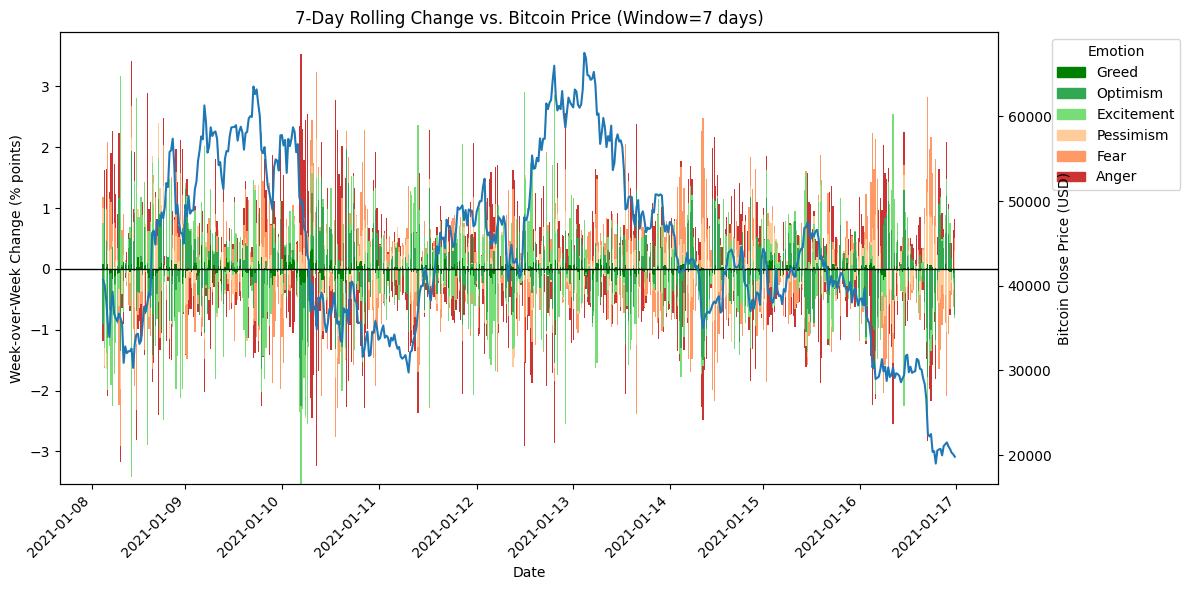

In [10]:
# -- Plot week-over-week rolling change with BTC overlay --
fig, ax1 = plt.subplots(figsize=(12, 6))
# Zero line
ax1.axhline(0, color='black', linewidth=1, linestyle='-')

# Stack bars for positive and negative changes
bottom_pos = np.zeros(len(dates))
bottom_neg = np.zeros(len(dates))
for emotion in emotion_order:
    # positive
    vals_pos = pos_dev[emotion].values
    ax1.bar(dates, vals_pos, bottom=bottom_pos, color=emotion_colors[emotion], width=0.8)
    bottom_pos += vals_pos
    # negative
    vals_neg = neg_dev[emotion].values
    ax1.bar(dates, -vals_neg, bottom=bottom_neg, color=emotion_colors[emotion], width=0.8)
    bottom_neg -= vals_neg

# Formatting
ax1.set_xlabel('Date')
ax1.set_ylabel('Week-over-Week Change (% points)')
ax1.set_title(f'7-Day Rolling Change vs. Bitcoin Price (Window={window} days)')
ax1.set_xticklabels([d.strftime('%Y-%m-%d') for d in dates], rotation=45, ha='right')
handles = [plt.Rectangle((0,0),1,1, color=emotion_colors[e]) for e in emotion_order]
ax1.legend(handles, emotion_order, title='Emotion', bbox_to_anchor=(1.05, 1), loc='upper left')

# Bitcoin overlay
ax2 = ax1.twinx()
ax2.plot(dates, btc_aligned.values, linestyle='-')
ax2.set_ylabel('Bitcoin Close Price (USD)')

plt.tight_layout()
plt.show()


NameError: name 'roll_avg' is not defined

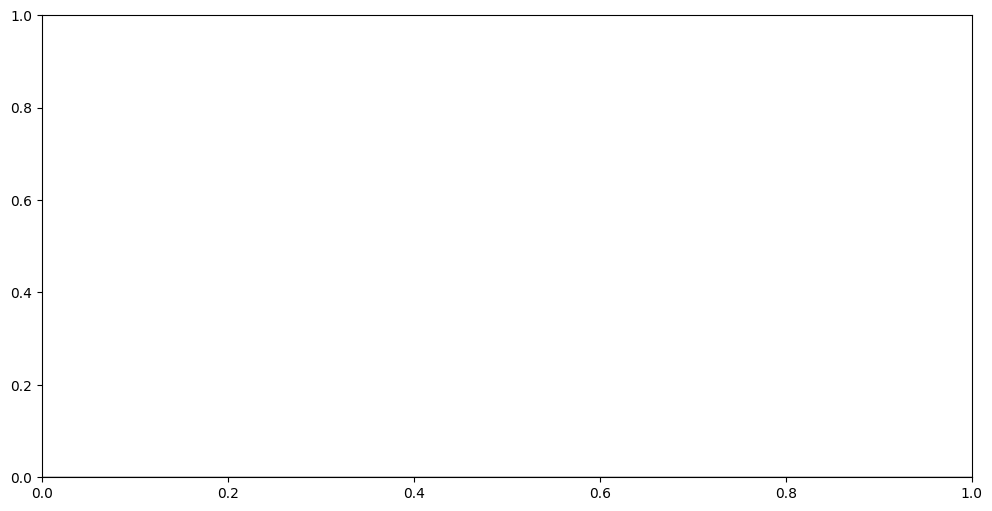

In [11]:
# -- Plot rolling average deviations with BTC overlay --
fig, ax1 = plt.subplots(figsize=(12, 6))
# Draw zero line for clarity
ax1.axhline(0, color='black', linewidth=1, linestyle='-')

# Stack bars for rolling average
bottom_pos = np.zeros(len(dates))
bottom_neg = np.zeros(len(dates))
for emotion in emotion_order:
    vals_pos = roll_avg[emotion].clip(lower=0).values  # Use rolling average
    ax1.bar(dates, vals_pos, bottom=bottom_pos, color=emotion_colors[emotion], width=0.8)
    bottom_pos += vals_pos

    vals_neg = roll_avg[emotion].clip(upper=0).values  # Use rolling average
    ax1.bar(dates, vals_neg, bottom=bottom_neg, color=emotion_colors[emotion], width=0.8)
    bottom_neg += vals_neg

# Formatting
ax1.set_xlabel('Date')
ax1.set_ylabel('Rolling Average Distribution (%)')
ax1.set_title(f'7-Day Rolling Average Emotion Distribution vs. Bitcoin Price (Window={window} days)')
ax1.set_xticklabels([d.strftime('%Y-%m-%d') for d in dates], rotation=45, ha='right')

# Custom legend
handles = [plt.Rectangle((0,0),1,1, color=emotion_colors[e]) for e in emotion_order]
ax1.legend(handles, emotion_order, title='Emotion', bbox_to_anchor=(1.05, 1), loc='upper left')

# Bitcoin overlay
ax2 = ax1.twinx()
ax2.plot(dates, btc_aligned.values, linestyle='-', color='blue', label='BTC Price')
ax2.set_ylabel('Bitcoin Close Price (USD)')

plt.tight_layout()
plt.show()

C:\Users\pryty\AppData\Local\Temp\ipykernel_14564\3199164012.py:22: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax1.set_xticklabels([d.strftime('%Y-%m-%d') for d in dates], rotation=45, ha='right')


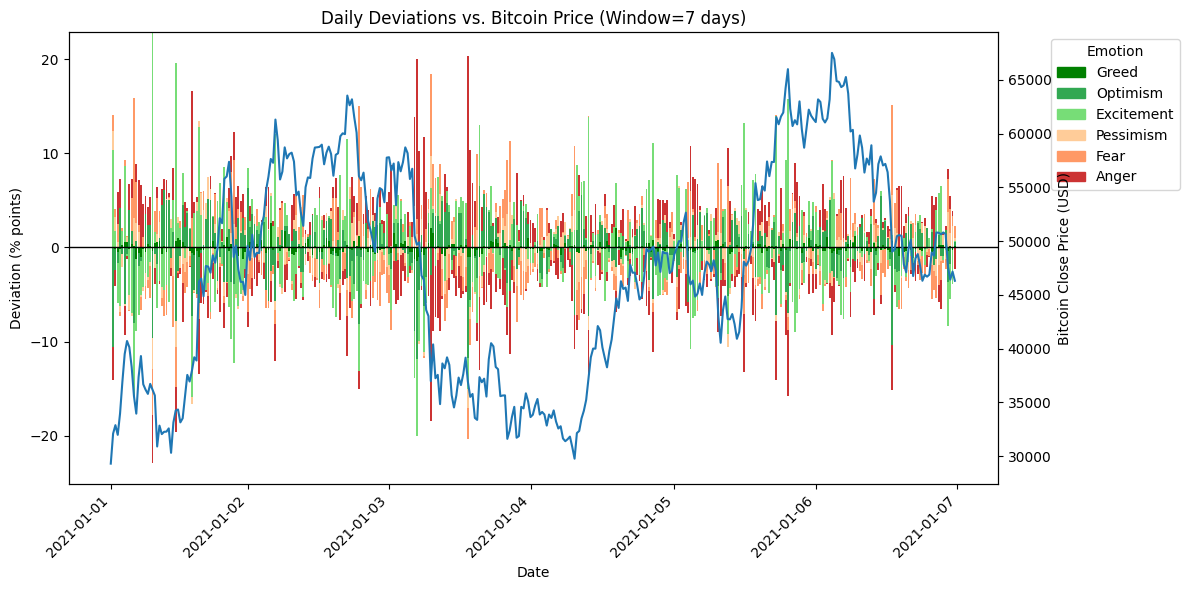

In [19]:
# -- Plot deviations with BTC overlay --
fig, ax1 = plt.subplots(figsize=(12, 6))
# Draw zero line for clarity
ax1.axhline(0, color='black', linewidth=1, linestyle='-')

# Stack bars
bottom_pos = np.zeros(len(dates))
bottom_neg = np.zeros(len(dates))
for emotion in emotion_order:
    vals_pos = pos_dev[emotion].values
    ax1.bar(dates, vals_pos, bottom=bottom_pos, color=emotion_colors[emotion], width=0.8)
    bottom_pos += vals_pos

    vals_neg = neg_dev[emotion].values
    ax1.bar(dates, -vals_neg, bottom=bottom_neg, color=emotion_colors[emotion], width=0.8)
    bottom_neg -= vals_neg

# Formatting
ax1.set_xlabel('Date')
ax1.set_ylabel('Deviation (% points)')
ax1.set_title(f'Daily Deviations vs. Bitcoin Price (Window={window} days)')
ax1.set_xticklabels([d.strftime('%Y-%m-%d') for d in dates], rotation=45, ha='right')

# Custom legend
handles = [plt.Rectangle((0,0),1,1, color=emotion_colors[e]) for e in emotion_order]
ax1.legend(handles, emotion_order, title='Emotion', bbox_to_anchor=(1.05, 1), loc='upper left')

# Bitcoin overlay
ax2 = ax1.twinx()
ax2.plot(dates, btc_aligned.values, linestyle='-')
ax2.set_ylabel('Bitcoin Close Price (USD)')

plt.tight_layout()
plt.show()
